In [1]:
import glob
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "2"
import pickle
import sys

# From arm
import cv2
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.optim as optim
from scipy.signal import savgol_filter
from scipy.spatial.distance import euclidean
from sklearn.linear_model import Lasso, LassoCV, LinearRegression, Ridge, RidgeCV
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from tqdm import tqdm

from MouseArmTransformer import (
    criterion,
    data,
    helper,
    inference,
    model,
    training,
)
from mausspaun.visualization.plot_3D_video import plot_3d_video, plot_split_3d_video
from mausspaun.datajoint import analysis

%load_ext autoreload
%autoreload 2

In [2]:
scan_key_list = [{'mouse_name': 'HoneyBee', 'day': 77, 'attempt': 1, 'scan_idx': 0},
        {'mouse_name': 'HoneyBee', 'day': 81, 'attempt': 1, 'scan_idx': 0},
        {'mouse_name': 'HoneyBee', 'day': 82, 'attempt': 1, 'scan_idx': 0},
        {'mouse_name': 'HoneyBee', 'day': 84, 'attempt': 1, 'scan_idx': 0},
        {'mouse_name': 'HoneyBee', 'day': 86, 'attempt': 1, 'scan_idx': 0},
        {'mouse_name': 'Jaguar', 'day': 19, 'attempt': 1, 'scan_idx': 0},
        {'mouse_name': 'HoneyBee', 'day': 83, 'attempt': 1, 'scan_idx': 0}] # Force field

In [3]:
# Define base path for all sessions
base_data_path = '/data/mausspaun/without_muscles/session_data_Apr17/'

all_errors = []
for scan_key in scan_key_list:
    print(scan_key)
    mouse_path = f"mouse-{scan_key['mouse_name']}_day-{scan_key['day']}_attempt-{scan_key['attempt']}"
    try:
        mouse_data = np.load(base_data_path + mouse_path + '.npy', allow_pickle=True)[()]
    except:
        print('Skipping {}'.format(scan_key))
        continue
    
    transformer_3D = mouse_data['mujoco_dlc_3d']
    
    avg_error, errors, labeled_3d = inference.evaluate_ground_truth(transformer_3D, scan_key['mouse_name'], scan_key['day'], scan_key['attempt'], verbose=0)
    
    scan_key_str = f"{scan_key['mouse_name']}_day-{scan_key['day']}_attempt-{scan_key['attempt']}"
    errors['scan_key'] = scan_key_str
    
    all_errors.append(errors)
    
aggregated_errors = pd.concat(all_errors, ignore_index=True)

{'mouse_name': 'HoneyBee', 'day': 77, 'attempt': 1, 'scan_idx': 0}
--- Found labels at /data/mausspaun/labeled/rigVideo_mouse-HoneyBee_day-77_attempt-1_part-0_2024-01-18_09-15_points3d_diff.csv
Connecting to robot config...
MuJoCo session created
MuJoCO session closed...
Procrustes alignment error: 0.008391397293761028
{'mouse_name': 'HoneyBee', 'day': 81, 'attempt': 1, 'scan_idx': 0}
--- Found labels at /data/mausspaun/labeled/rigVideo_mouse-HoneyBee_day-81_attempt-1_part-0_2024-01-23_10-55_points3d_diff.csv
Connecting to robot config...
MuJoCo session created
MuJoCO session closed...
Procrustes alignment error: 0.008391397293761028
{'mouse_name': 'HoneyBee', 'day': 82, 'attempt': 1, 'scan_idx': 0}
--- Found labels at /data/mausspaun/labeled/rigVideo_mouse-HoneyBee_day-82_attempt-1_part-0_2024-01-23_10-43_points3d_diff.csv
Connecting to robot config...
MuJoCo session created
MuJoCO session closed...
Procrustes alignment error: 0.008391397293761028
{'mouse_name': 'HoneyBee', 'day': 84,

In [4]:
aggregated_errors.to_csv('labeled_vs_lifted.csv')

In [15]:
aggregated_errors['scan_key'].unique()

array(['HoneyBee_day-77_attempt-1', 'HoneyBee_day-81_attempt-1',
       'HoneyBee_day-82_attempt-1', 'HoneyBee_day-86_attempt-1'],
      dtype=object)

In [ ]:
aggregated_errors['marker'].unique()

In [ ]:
plt.style.use('default')

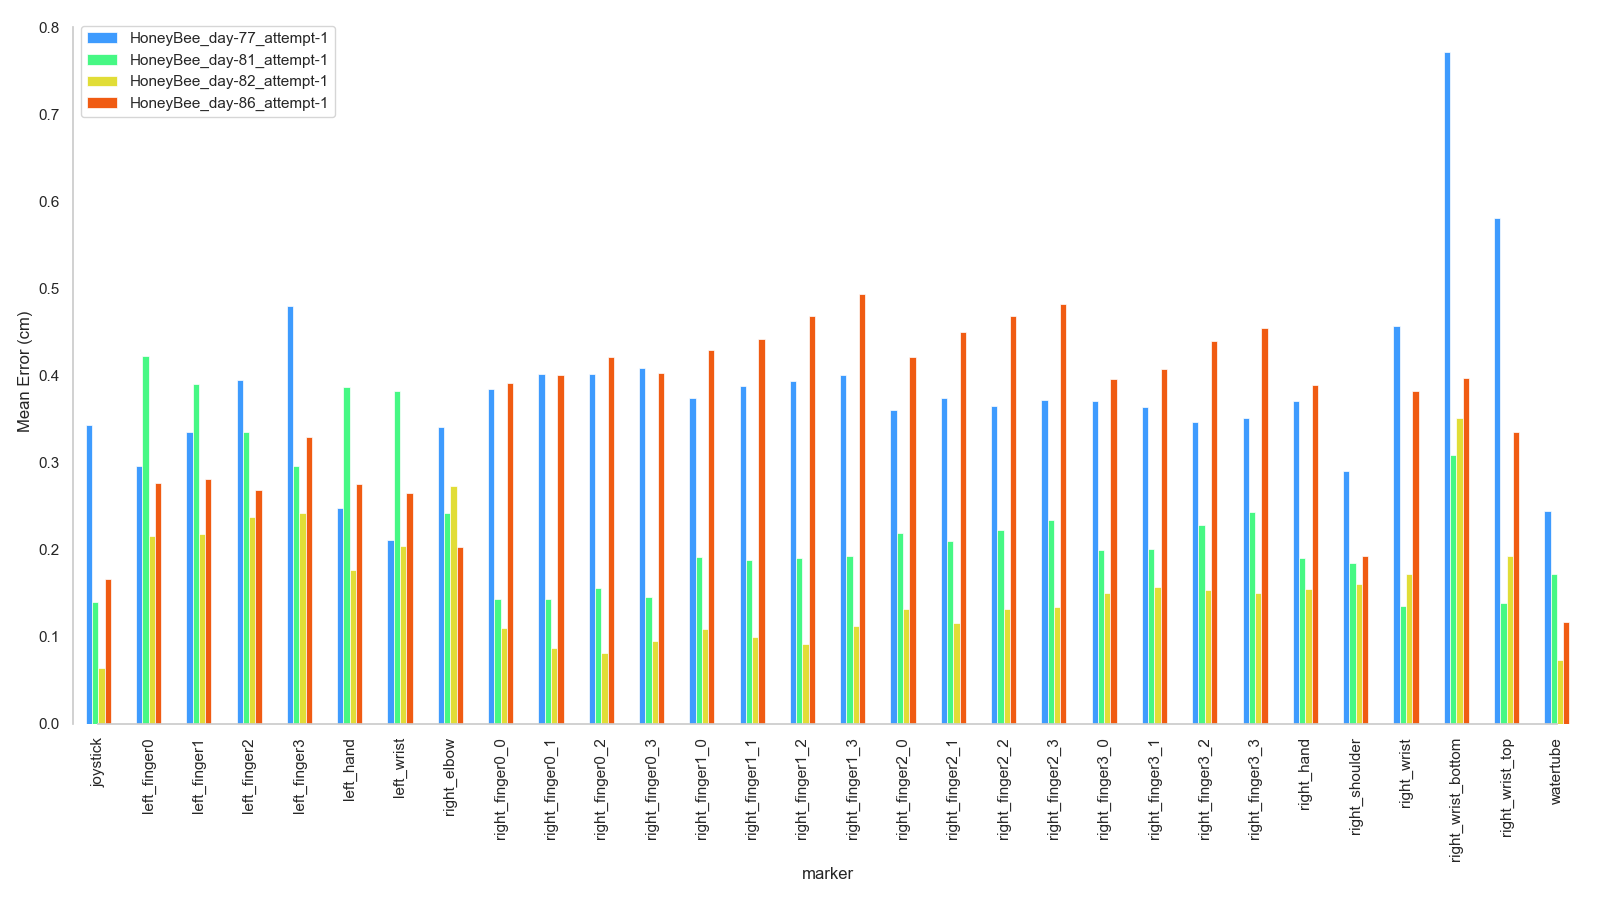

In [18]:
filtered_errors = aggregated_errors[~aggregated_errors['marker'].isin(['left_elbow', 'lick', 'nose'])]

mean_errors = filtered_errors.groupby(['scan_key', 'marker'])['error'].mean().unstack()
colors = sns.color_palette("turbo", len(mean_errors.index))
mean_errors.T.plot(kind='bar', figsize=(16, 9), color=colors, linewidth=0.5)

# plt.xlabel('Marker')
plt.ylabel('Mean Error (cm)')
#plt.legend(title='Session', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.legend()
plt.xticks(rotation=90)
plt.grid(False)
plt.tight_layout()

sns.despine(trim=True)
plt.savefig('./transformer_error_mean_filtered.svg', transparent=True)
plt.show()

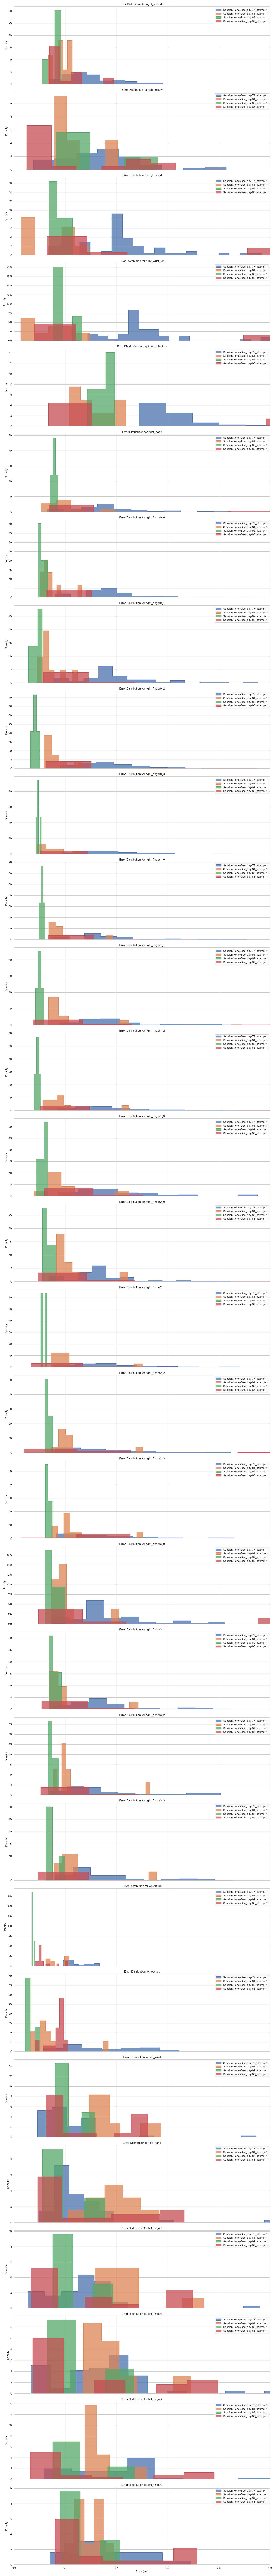

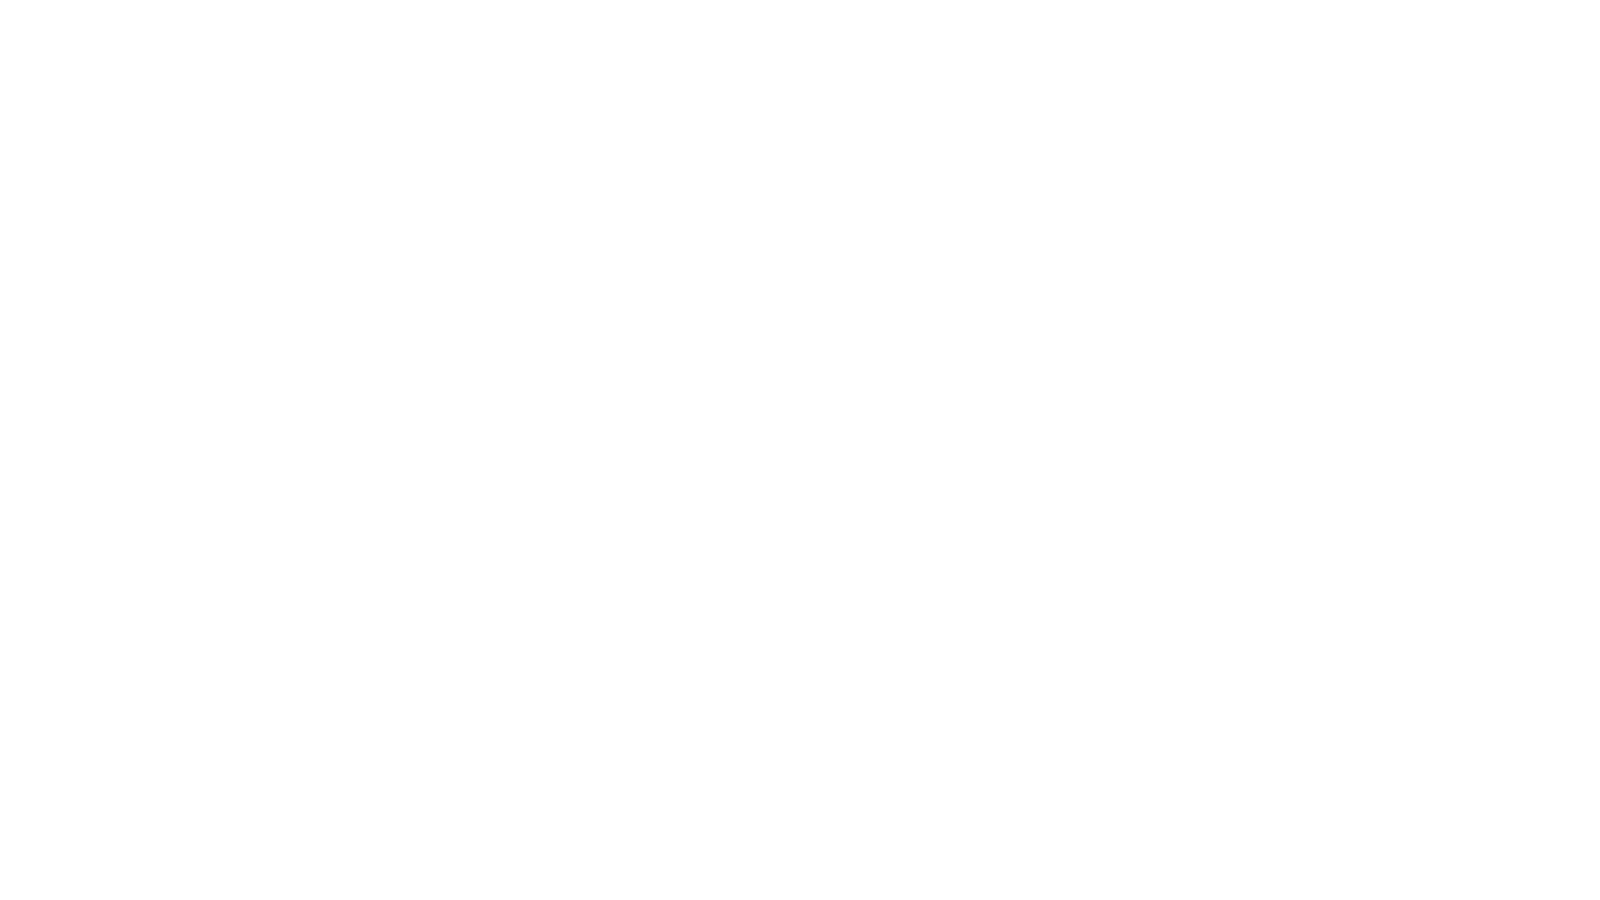

In [19]:
filtered_errors = aggregated_errors[~aggregated_errors['marker'].isin(['left_elbow', 'lick', 'nose'])]
plt.figure(figsize=(16, 9))


scan_keys = filtered_errors['scan_key'].unique()
markers = filtered_errors['marker'].unique()

num_markers = len(markers)
fig, axes = plt.subplots(num_markers, 1, figsize=(16, 5 * num_markers), sharex=True)

for i, marker in enumerate(markers):
    marker_data = filtered_errors[filtered_errors['marker'] == marker]
    for scan_key in scan_keys:
        session_data = marker_data[marker_data['scan_key'] == scan_key]['error']
        sns.histplot(session_data, ax=axes[i], kde=False, label=f'Session {scan_key}', element="step", stat="density", common_norm=False)
    
    axes[i].set_title(f'Error Distribution for {marker}')
    axes[i].set_xlabel('Error (cm)')
    axes[i].legend()
    axes[i].set_xlim([0, 1])

axes[-1].set_xlabel('Error (cm)')
plt.tight_layout()
plt.show()

plt.savefig('./transformer_error_histograms.svg', transparent=True)

---
# Animation

In [5]:
session_data = aggregated_errors[aggregated_errors['scan_key'] == 'HoneyBee_day-77_attempt-1']

In [6]:
%matplotlib widget

In [7]:
plt.close('all')

In [8]:
sns.set_theme(style="whitegrid")

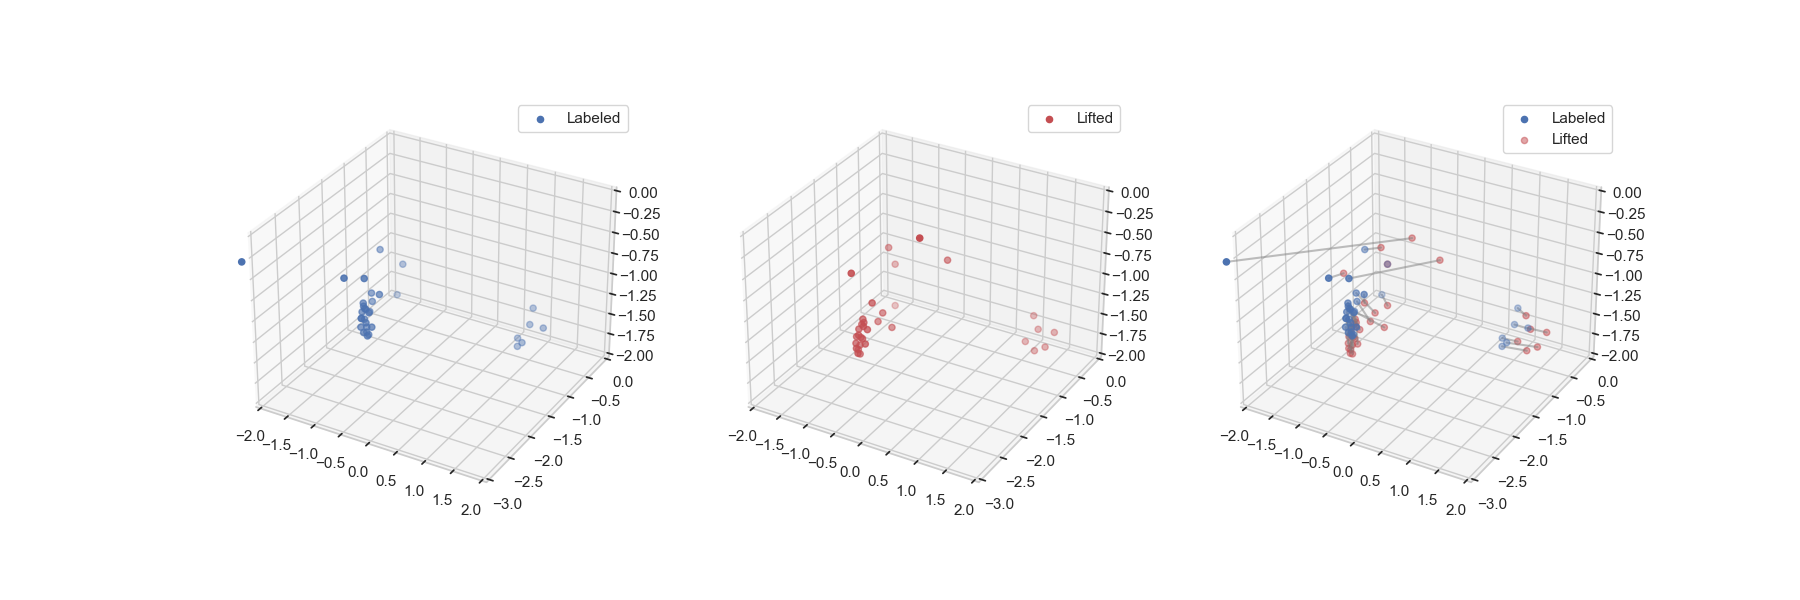

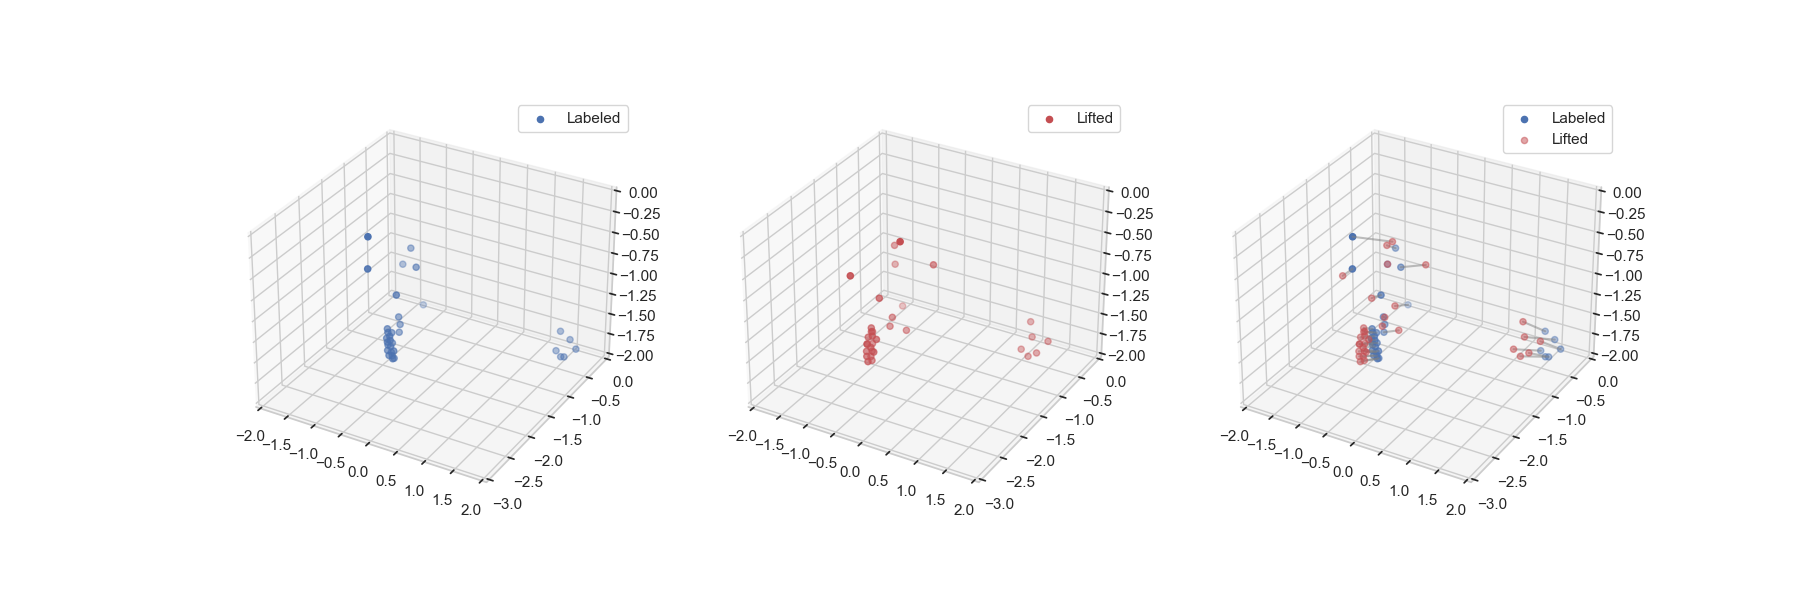

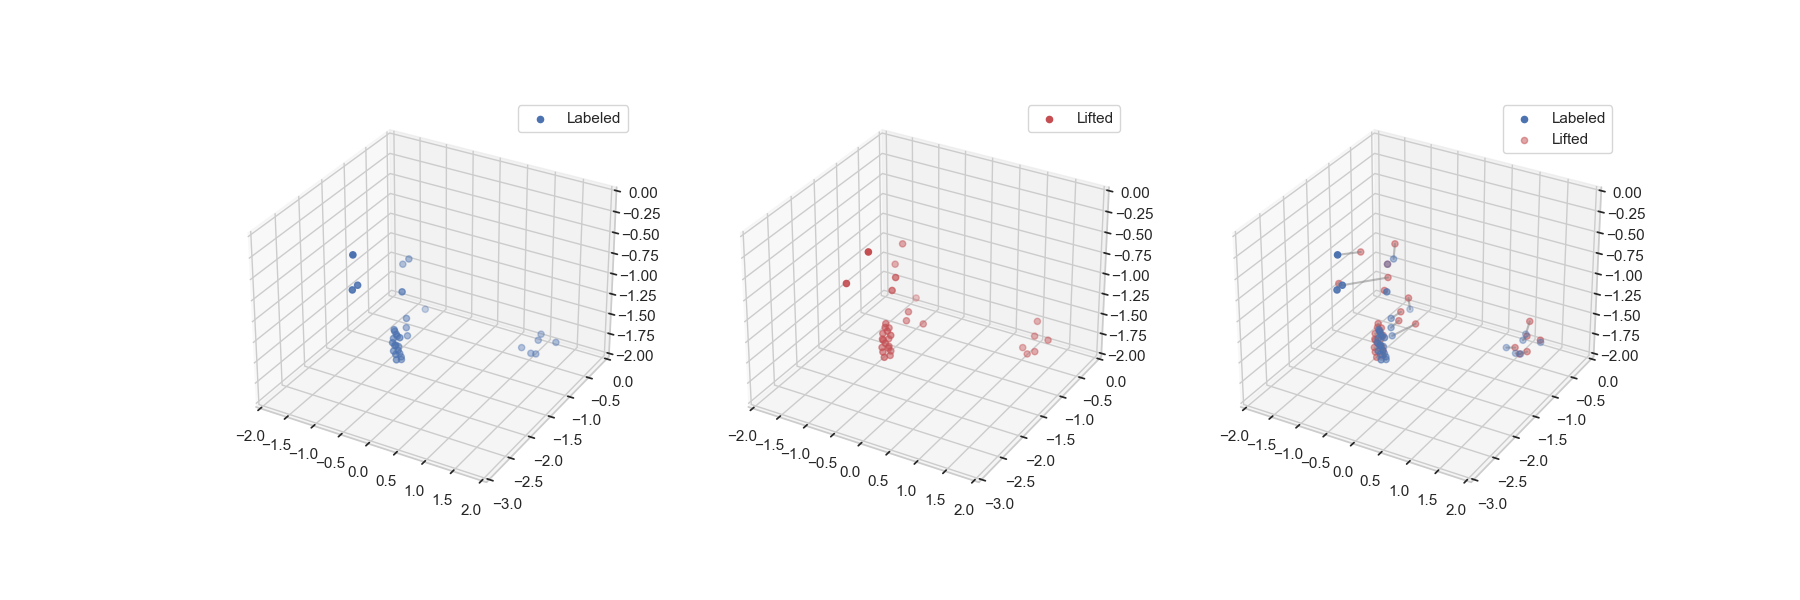

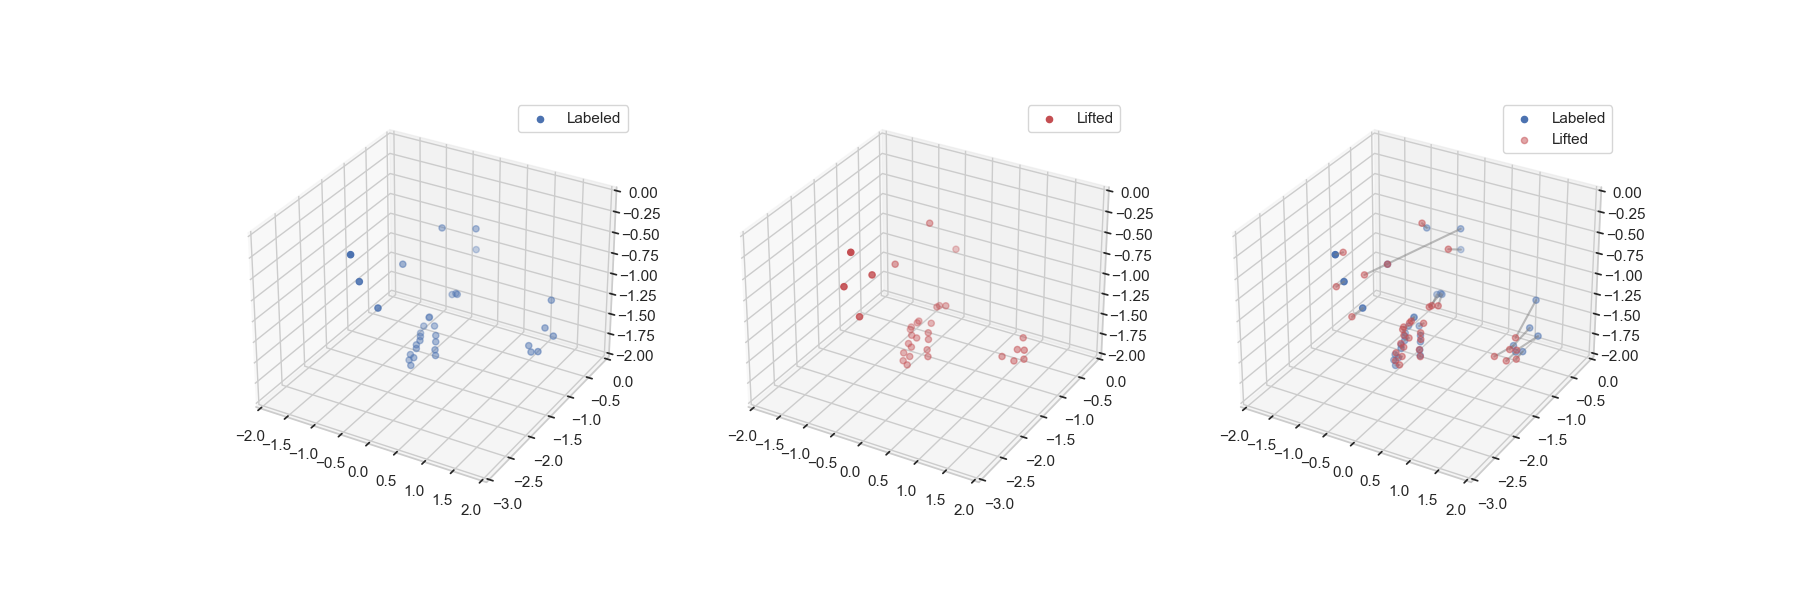

In [17]:
unique_sessions = aggregated_errors['scan_key'].unique()
for session in unique_sessions:
    #session = 'HoneyBee_day-77_attempt-1'
    session_data = aggregated_errors[aggregated_errors['scan_key'] == session]
    frames = session_data['frame'].unique()

    fig = plt.figure(figsize=(18, 6))
    ax1 = fig.add_subplot(131, projection='3d', title='Labeled Data')
    ax2 = fig.add_subplot(132, projection='3d', title='Lifted Data')
    ax3 = fig.add_subplot(133, projection='3d', title='Overlay')

    def update(frame):
        ax1.clear()
        ax2.clear()
        ax3.clear()

        frame_data = session_data[session_data['frame'] == frame]
        ax1.scatter(frame_data['labeled_x'], frame_data['labeled_y'], frame_data['labeled_z'], c='b', label='Labeled')
        ax2.scatter(frame_data['lifted_x'], frame_data['lifted_y'], frame_data['lifted_z'], c='r', label='Lifted')

        ax3.scatter(frame_data['labeled_x'], frame_data['labeled_y'], frame_data['labeled_z'], c='b', label='Labeled')
        ax3.scatter(frame_data['lifted_x'], frame_data['lifted_y'], frame_data['lifted_z'], c='r', alpha=0.5, label='Lifted')
        for i in range(len(frame_data)):
            ax3.plot([frame_data['labeled_x'].iloc[i], frame_data['lifted_x'].iloc[i]],
                     [frame_data['labeled_y'].iloc[i], frame_data['lifted_y'].iloc[i]],
                     [frame_data['labeled_z'].iloc[i], frame_data['lifted_z'].iloc[i]], 'gray', alpha=0.5)

        ax1.legend()
        ax2.legend()
        ax3.legend()

        limit = ((-2, 2), (-3, 0), (-2, 0))
        ax1.set_xlim(limit[0])
        ax1.set_ylim(limit[1])
        ax1.set_zlim(limit[2])
        ax2.set_xlim(limit[0])
        ax2.set_ylim(limit[1])
        ax2.set_zlim(limit[2])
        ax3.set_xlim(limit[0])
        ax3.set_ylim(limit[1])
        ax3.set_zlim(limit[2])

    ani = FuncAnimation(fig, update, frames=frames, repeat=False)

    ani.save('{}.mp4'.format(session), writer='ffmpeg', fps=1, dpi=300)

    #plt.show()

In [ ]:
plt.close('all')

---

In [ ]:
from MouseArmTransformer.gui import utils

In [ ]:
original_filepaths = utils.generate_filepaths('/data/mausspaun/' + 'videos/videos_dlc2/', 'Jaguar', 19, 1, 0)

In [ ]:
aggregated_errors